In [1]:
#librerías
import numpy as np
import matplotlib.pyplot as plt #gráficos
from scipy import interpolate #interpolación 1
from scipy.interpolate import griddata #interpolación 2
import h5py #archivos en hdf5
from jupyterlab_h5web import H5Web #librería
from pathlib import Path, PurePath #manejo de rutas y archivos
%run -i ./Funciones.py #funciones importante

#idioma = 'español'
idioma = 'ingles'

#Graficación

if idioma == 'español':
    #plt.prop_cycle(color=['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97'])
    #axes.prop_cycle : cycler('color', ['0C5DA5', '00B945', 'FF9500', 'FF2C00', '845B97', '474747', '9e9e9e'])
    #Latex y coma como separador decimal
    plt.rcParams['text.usetex'] = True #latex
    #plt.rc('text', usetex=False)
    plt.rcParams['axes.formatter.use_locale'] = True #formato de eje para la coma
    #se incluye paquete matematico útil, se corrige el error con el espacio y el espacio entre los números
    plt.rc('text.latex', preamble=r'\usepackage{amsmath} \DeclareUnicodeCharacter{202F}{\,} \usepackage{ziffer} \usepackage{siunitx}') 
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
    })
    import locale #líbreria para el formato
    locale.setlocale(locale.LC_ALL, "es_CR.utf8")

if idioma == 'ingles' :
    plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{siunitx}')
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
    })


(98, 40, 48)


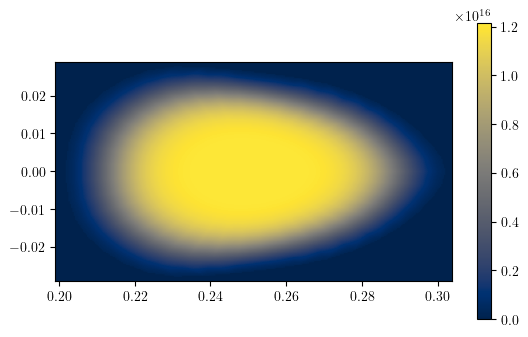

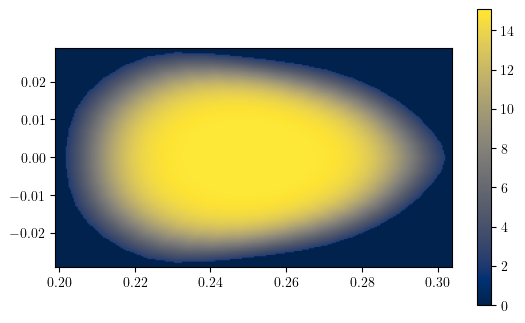

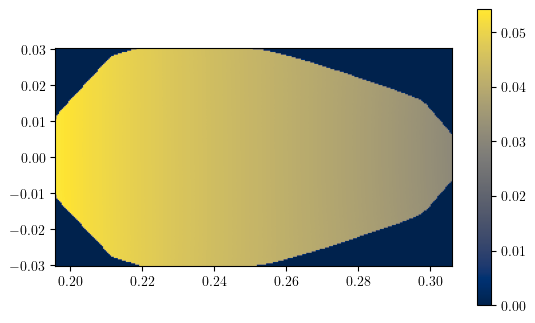

In [2]:
ruta_campo = 'ne_Te_r_z_B/r+z+B_mag_componentes.txt'
ruta_ne = 'ne_Te_r_z_B/densidad.txt'
ruta_Te = 'ne_Te_r_z_B/temperatura.txt'

n_e = np.loadtxt(ruta_ne)
T_e = np.loadtxt(ruta_Te)
r_BS, z_BS, B_x,B_y,B_z = np.loadtxt(ruta_campo, usecols=(0, 1, 2, 3, 4), unpack=True)

r_vmec, z_vmec = variables_vmec('input_VMEC', 'wout_scr_free.nc')
r,z = eliminar_eje_magnetico(r_vmec, z_vmec)
s2DB = campo_magnetico_mapa(r_BS, z_BS)
superficie_2D, ne1, Te1 = densidad_electronica_mapa(r,z,n_e, T_e)
ne_interpol = input_densidad(superficie_2D, ne1)
Te_interpol = input_densidad(superficie_2D, Te1)
B_xint, B_yint, B_zint = input_campo(s2DB, B_x, B_y, B_z)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


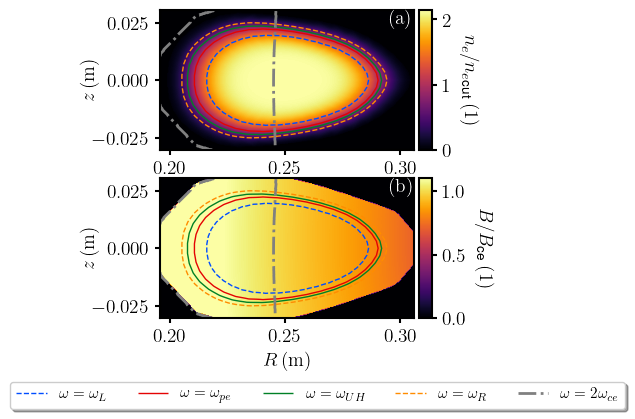

In [7]:
def plot_densidad_campoB(sup_2D_ne, ne1, sup_2D_B, Bx, By, Bz):
    #Regiones importantes
    ne_norm = np.loadtxt('./regiones_importantes/ne_norm.txt')
    wuh_norm = np.loadtxt('./regiones_importantes/wuh_214.txt')
    wR_norm = np.loadtxt('./regiones_importantes/wR_norm.txt')
    wce_norm = np.loadtxt('./regiones_importantes/wec_norm.txt')
    wL_norm = np.loadtxt('./regiones_importantes/wL_norm.txt')
    levels = np.arange(1.0, 1.01, 1) #O mode cut-off
    levels1 = np.arange(0.5,0.501, 0.5) # frecuencia de la onda incidente es el doble de la frecuencia ciclotrónica electrónica
    
    #Se crea una malla
    grid_r, grid_z = np.mgrid[0.1957178997475323:0.3060799:297j, -0.03031574:0.03031574:165j] #cero grados - vmec
    
    ne_corte = 7.45e16
    fac = 2.14
    factor_densidad = 6.1405*fac
    #Interpolación - valores - griddata
    grid_Bx = griddata(sup_2D_B, np.abs(Bx), (grid_r, grid_z), method='linear', fill_value = 0)
    grid_By = griddata(sup_2D_B, np.abs(By), (grid_r, grid_z), method='linear', fill_value = 0)
    grid_Bz = griddata(sup_2D_B, np.abs(Bz), (grid_r, grid_z), method='linear', fill_value = 0)
    grid_ne = griddata(sup_2D_ne, ne1.T*factor_densidad, (grid_r, grid_z), method='linear', fill_value = 0)
    
    B_neto = np.sqrt( np.power(grid_Bx,2) + np.power(grid_By,2) + np.power(grid_Bz,2) )
    B_promedio = 43.8e-3
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    #Gráficos
    #fig, (ax1,ax2) = plt.subplots(2)
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,4))
    cmap= "inferno" # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    
    c_ne = ax[0].imshow(grid_ne.T/ne_corte, extent=(0.1957178997475323, 0.3060799, -0.03031574, 0.03031574), 
                                   cmap=cmap, vmin=0, vmax=2.14)
    c_B = ax[1].imshow(B_neto.T/B_promedio, extent=(0.1957178997475323, 0.3060799, -0.03031574, 0.03031574), 
                                   cmap=cmap, vmin=0, vmax=1.1)
    


    # Crear barras de colores
    divider1 = make_axes_locatable(ax[0])
    divider2 = make_axes_locatable(ax[1])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)

    cbar_ne = fig.colorbar(c_ne, cax=cax1, orientation='vertical', shrink=0.9)
    cbar_B = fig.colorbar(c_B, cax=cax2, orientation='vertical', shrink=0.9)
    #cbar_ne.set_label(r'$n_{e}/n_{e\text{corte}} \left( 1 \right)$',  
                  #fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'}, rotation=270, labelpad=20) #labelpad - alejar etiqueta del eje
    cbar_ne.set_label(r'$n_{e}/n_{e\text{cut}} \left( 1 \right)$',  
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'}, rotation=270, labelpad=20) #labelpad - alejar etiqueta del eje
    cbar_B.set_label(r'$B/B_{\text{ce}} \left( 1 \right)$',  
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'}, rotation=270, labelpad=20) #labelpad - alejar etiqueta del eje
    ax[0].set_ylabel(r'$ z \left( \si{\metre} \right)$', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'}, labelpad = -5)
    ax[1].set_ylabel(r'$ z \left( \si{\metre} \right)$', 
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'}, labelpad = -5)
    ax[1].set_xlabel(r'$ R \left( \si{\metre} \right)$',  
                  fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    
    ax[0].tick_params(axis='both', labelsize=14, width=1.5)
    ax[1].tick_params(axis='both', labelsize=14, width=1.5)
    cbar_ne.ax.tick_params(labelsize=14, width=1.5)
    cbar_B.ax.tick_params(labelsize=14, width=1.5)
    
    
    omode = ax[0].contour(grid_r,grid_z,  ne_norm, levels, linestyles = 'solid', colors = '#e40303', linewidths = 1) # to plot the contour
    uh = ax[0].contour(grid_r,grid_z, wuh_norm, levels, linestyles = 'solid', colors = '#008026', linewidths = 1)
    ce = ax[0].contour(grid_r,grid_z, wce_norm, levels1, linestyles = 'dashdot', colors = 'gray', linewidths =2)
    R = ax[0].contour(grid_r,grid_z,  wR_norm, levels, linestyles = 'dashed', colors = '#ff8c00', linewidths =1)
    L = ax[0].contour(grid_r,grid_z,  wL_norm, levels, linestyles = 'dashed', colors = '#004dff', linewidths =1)
    
    omode = ax[1].contour(grid_r,grid_z,  ne_norm, levels, linestyles = 'solid', colors = '#e40303', linewidths = 1) # to plot the contour
    uh = ax[1].contour(grid_r,grid_z, wuh_norm, levels, linestyles = 'solid', colors = '#008026', linewidths = 1)
    ce = ax[1].contour(grid_r,grid_z, wce_norm, levels1, linestyles = 'dashdot', colors = 'gray', linewidths =2)
    R = ax[1].contour(grid_r,grid_z,  wR_norm, levels, linestyles = 'dashed', colors = '#ff8c00', linewidths =1)
    L = ax[1].contour(grid_r,grid_z,  wL_norm, levels, linestyles = 'dashed', colors = '#004dff', linewidths =1)
    
    #ejes en igual proporción
    #plt.gca().set_aspect("equal")
    plt.setp(ax[0].spines.values(), linewidth=1.5)
    plt.setp(ax[1].spines.values(), linewidth=1.5)
    cbar_ne.outline.set_linewidth(1.5) #ancho del borde de la barra
    cbar_B.outline.set_linewidth(1.5) #ancho del borde de la barra
    
    #Leyenda en mapa de calor
    cont_0,_ = L.legend_elements()
    cont_1,_ = omode.legend_elements()
    cont_2,_ = uh.legend_elements()
    cont_3,_ = R.legend_elements()
    cont_4,_ = ce.legend_elements()
    ax[0].text(0.9,0.9, r"\color{white} {$\textrm{(a)}$}", fontsize =14, fontdict=None, color='white', transform=ax[0].transAxes ) #Etiquetar gráfica
    ax[1].text(0.9,0.9, r'$\textrm{(b)}$', fontsize =14, fontdict=None, color='white', transform=ax[1].transAxes) #Etiquetar gráfica 
    
    
    
    plt.legend([cont_0[0], cont_1[0], cont_2[0], cont_3[0], cont_4[0]], 
               [r'{$\omega = \omega_{L}$}', r'{ $\omega = \omega_{pe}$ }', r'{$\omega = \omega_{UH}$}', r'{$\omega = \omega_{R}$}', 
                r'{$\omega = 2 \omega_{ce}$}'], fontsize = 11, loc='center', frameon=True,  bbox_to_anchor=(-8, -0.55),   ncol=5,  fancybox=True, shadow=True)
    
    if idioma == 'español':
        plt.savefig('ne_B_contornos.png', dpi=300, bbox_inches='tight') 
    if idioma == 'ingles' :
        plt.savefig('ne_B_contornos.eps', format='eps', dpi=300, bbox_inches='tight') #paper IOP
    
    
    plt.show()
    
plot_densidad_campoB(superficie_2D, ne1, s2DB, B_x, B_y, B_z)

In [ ]:
def posicion_UHR(ne_interpol1, factor_densidad1, fact1, angulo, B_xint1, B_yint1, B_zint1):
    from scipy.constants import e, m_e, epsilon_0 #constantes físicas
    f_calentamiento1 = 2.45e9
    omega1 =  2*np.pi*f_calentamiento1
    
    #campo magnético neto
    B_neto1 = np.sqrt( np.power(B_xint1,2) + np.power(B_yint1,2) + np.power(B_zint1,2) )
    wpe1 = ((factor_densidad1*fact1*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0) #cuadrado de la frecuencia
    wce1 = ((e)/(m_e))*B_neto1*0.975
    wuh_norm1 = (np.sqrt(np.power(wce1,2) + wpe1))/omega1

    
    grid_r, grid_z = np.mgrid[0.19893:0.303797:297j, -0.0289025:0.0289019:165j]
    levels = np.arange(1.0, 1.01, 1)
    uh = plt.contour(grid_r,grid_z, wuh_norm1, levels, linestyles = 'dashed', colors = 'red', linewidths = 1)
    plt.close() #no mostrar el gráfico
    
    for item1 in uh.collections:
        for i11 in item1.get_paths():
            v11 = i11.vertices
            x11 = v11[:, 0]
            y11 = v11[:, 1]
    
    #if angulo > 180 and angulo < 360 :
        #angulo = angulo - 360       
    
    angulo_uh = np.arctan2(-y11, (x11-0.247))
    index = find_nearest1(angulo_uh, np.radians(angulo))
    plt.scatter(x11[index], y11[index])
    #Radio
    r = np.sqrt((x11[index]-0.247)**2 + y11[index]**2)
    print(r)
    plt.plot(x11, y11)
    
    return x11[index], y11[index]
posicion_UHR(ne_interpol, 6.1405, 2.14, 24, B_xint, B_yint, B_zint)

In [ ]:
def posicion_modo_O(ne_interpol1, factor_densidad1, fact1, angulo, B_xint1, B_yint1, B_zint1):
    from scipy.constants import e, m_e, epsilon_0 #constantes físicas
    f_calentamiento1 = 2.45e9
    omega1 =  2*np.pi*f_calentamiento1
    
    wpe1_norm = np.sqrt( ((factor_densidad1*fact1*ne_interpol1)*np.power(e,2))/(m_e*epsilon_0)) /omega1 #cuadrado de la frecuencia
    grid_r, grid_z = np.mgrid[0.19893:0.303797:297j, -0.0289025:0.0289019:165j]
    levels = np.arange(1.0, 1.01, 1)
    pe = plt.contour(grid_r,grid_z, wpe1_norm, levels, linestyles = 'dashed', colors = 'red', linewidths = 1)
    plt.close() #no mostrar el gráfico
    
    for item1 in pe.collections:
        for i11 in item1.get_paths():
            v11 = i11.vertices
            x11 = v11[:, 0]
            y11 = v11[:, 1]
    
    #if angulo > 180 and angulo < 360 :
        #angulo = angulo - 360       
    
    angulo_pe = np.arctan2(-y11, (x11-0.247))
    index = find_nearest1(angulo_pe, np.radians(angulo))
    #Radio
    r = np.sqrt((x11[index]-0.247)**2 + y11[index]**2)
    print(r)
    
    plt.scatter(x11[index], y11[index])
    plt.plot(x11, y11)
    
    return x11[index], y11[index]
posicion_modo_O(ne_interpol, 6.1405, 2.14, 24, B_xint, B_yint, B_zint)

In [ ]:
#Gráfico del valor de k0L_n en función de la posición de la UHR, debe buscarse el ángulo adecuado
f_calentamiento = 2.45e9
def k0lnvsxuhr(f,ne1, inf, sup, factor_ne, step) :
    from scipy.constants import e, m_e, epsilon_0, c #constantes físicas
    #posición uhr
    #aumento_factor_ne = np.arange(inf, sup, step)
    aumento_factor_ne = np.array([1.480, 1.573, 1.665, 1.758, 1.850, 1.995, 2.068, 2.14])
    n_filas = aumento_factor_ne.shape[0]
    uh_pos_r = np.ndarray((n_filas,), dtype=np.float64)
    uh_pos_z = np.ndarray((n_filas,), dtype=np.float64)
    uh_pos = np.ndarray((n_filas,), dtype=np.float64)
    for i in range(n_filas) :
        fact_final = factor_ne*aumento_factor_ne[i]
        #Usar para uhr
        uh_posr, uh_posz = posicion_UHR(ne_interpol, fact_final, aumento_factor_ne[i], 24, B_xint, B_yint, B_zint)
        #Usar para modo corte modo ordinario
        #uh_posr, uh_posz = posicion_modo_O(ne_interpol, fact_final, aumento_factor_ne[i], 25, B_xint, B_yint, B_zint)
        uh_pos_r[i] = uh_posr
        uh_pos_z[i] = uh_posz
        uh_pos[i] = np.sqrt(uh_posr**2 + uh_posz**2)
    #Cálculo de k0
    lambda_0 = c/(f)
    k_0 = 2*np.pi/lambda_0
    
    
    #Cálculo de L_n
    r = np.linspace(0.19893, 0.303797, 297)
    z = np.linspace(-0.0289025, 0.0289019, 165)
    delta_x = r[1]-r[0]
    delta_y = np.abs(z[1]-z[0])
    gradiente_x, gradiente_y = np.gradient(ne1, delta_x, delta_y) 
    ne1_grad = np.sqrt(gradiente_x**2 + gradiente_y**2)
    L_n = ne1 /(ne1_grad)
    
    L_n[L_n > 1e13] = 1
    
    z0=134
    print("la posición en z es", z[z0])
    plt.plot(r[0:297],k_0*L_n[0:297, z0])
    plt.scatter(0.264, 1.00)
    plt.scatter(0.270, 1.00)
    plt.scatter(0.275, 1.00)
    
    
        
    n_r = uh_pos_r.shape[0]
    n_z = uh_pos_z.shape[0]
    ind_Ln_r = np.ndarray((n_r,), dtype=np.float64)
    ind_Ln_z = np.ndarray((n_z,), dtype=np.float64)
    
    for j in range(n_r) : 
        ind_Ln_r[j] = np.searchsorted(r, uh_pos_r[j], side="left")
        ind_Ln_z[j] = np.searchsorted(z, uh_pos_z[j], side="left")
    
    L_n_final = L_n[ind_Ln_r.astype(int), ind_Ln_z.astype(int)]
    
    #print(L_n_final)
    #print(uh_pos_r-0.2477)
    
    #gráfico
    fig = plt.figure()  # create a figure object
    ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
    ax.plot(uh_pos_r, (k_0*L_n_final) , 'o-', linewidth=2, color= '#00B945')
    ax.plot(uh_pos_r[0], (k_0*L_n_final[0]), 'o', label=r'$n_{e}/n_{e\,corte} = \num{1.48}$', color='red')
    ax.plot(uh_pos_r[4], (k_0*L_n_final[4]), 'o', label=r'$n_{e}/n_{e\,corte} = \num{1.85}$', color='blue')
    ax.plot(uh_pos_r[7], (k_0*L_n_final[7]), 'o', label=r'$n_{e}/n_{e\,corte} = \num{2.14}$', color='purple')
    plt.legend(loc="upper right", fontsize =14)
    #print(k_0*L_n_final[0], k_0*L_n_final[4], k_0*L_n_final[7] )
    ax.set_ylabel(r'$ k_0L_{n} $ (1)', fontdict = {'fontsize':14, 'fontweight':'bold', 'color':'black'})
    ax.set_xlabel( r'$ R $ (\si{\metre})', 
                  fontdict = {'fontsize':12, 'fontweight':'bold', 'color':'black'})
    #ax.set_ylim(400, 700)
    ax.tick_params(axis='both', labelsize=14, width=1.5) 
    plt.setp(ax.spines.values(), linewidth=1.5)
    #plt.savefig('koLnvsR.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    
k0lnvsxuhr(f_calentamiento, ne_interpol, 1.48, 2.14, 6.1405, 0.1)